# Exercise 7 | Tube MPC

## Problem 1

Design a tube MPC controller for the following linear system:

$$x^+ = Ax + Bu + w,  A=\begin{bmatrix}1 & 1 \\ 0 & 1\end{bmatrix}, B=\begin{bmatrix}1 \\ 0.5\end{bmatrix} $$

with constraints and bounded disturbance

$$\mathcal{X} = \{x \mid \|x\|_{\infty} \leq 3 \}, \quad \mathcal{U} = \{u \mid ~\|u\|_{\infty} \leq 0.5 \} \quad \mathcal{W} = \{w \mid \|w\|_{\infty} \leq 0.1 \} $$

The matrix $K$ is the LQR gain with $Q=I$ and $R=10$.



In [1]:
import numpy as np
from mpt4py import Polyhedron
from control import dlqr

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

A = np.array([[1, 1], [0, 1]])
B = np.array([[1], [0.5]])
Q = np.eye(2)
R = 10 * np.eye(1)

K, Qf, _ = dlqr(A, B, Q, R)
K = -K
A_cl = A + B @ K

x_max = 3.
u_max = 0.5
w_max = 0.1

X = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=x_max*np.ones(4))
U = Polyhedron.from_Hrep(A=np.vstack((np.eye(1), -np.eye(1))), b=u_max*np.ones(2))
W = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=w_max*np.ones(4))


### Task 1
Implement a function to compute the minimum robust invariant set $\mathcal{E}$. 

Plot $\mathcal{X}$ and $\mathcal{E}$. How do you expect their Pontryagin difference $\mathcal{X}\ominus\mathcal{E}$ to look like?

**Hints:** 

- When computing your invariant sets, you will iterate through $\mathcal{F}_0, \mathcal{F}_1, \mathcal{F}_2, ...$ as we’ve seen in the lecture and the complexity of these sets will grow rapidly. Therefore, it’s a good idea to call `F.minHrep()` or `F.minVrep()` regularly to reduce the size of these sets. 

- Using the algorithm from the lectures leads to an infinite number of iterations and therefore you have to terminate it after a fixed number. Terminate when the size of the set you’re
adding is sufficiently small. A good termination condition will be $\|(A+BK)^i \|_2 < 10^{-2}$.

- The affine map of a polyhedron $P$ under a matrix $T$ is defined as $Q:=\{y \mid y=Tx, x\in P\}$. In *mpt4py*, this can be computed by `P.affine_map(T)` or `T @ P`.

Minimal robust invariant set computation converged after 16 iterations.


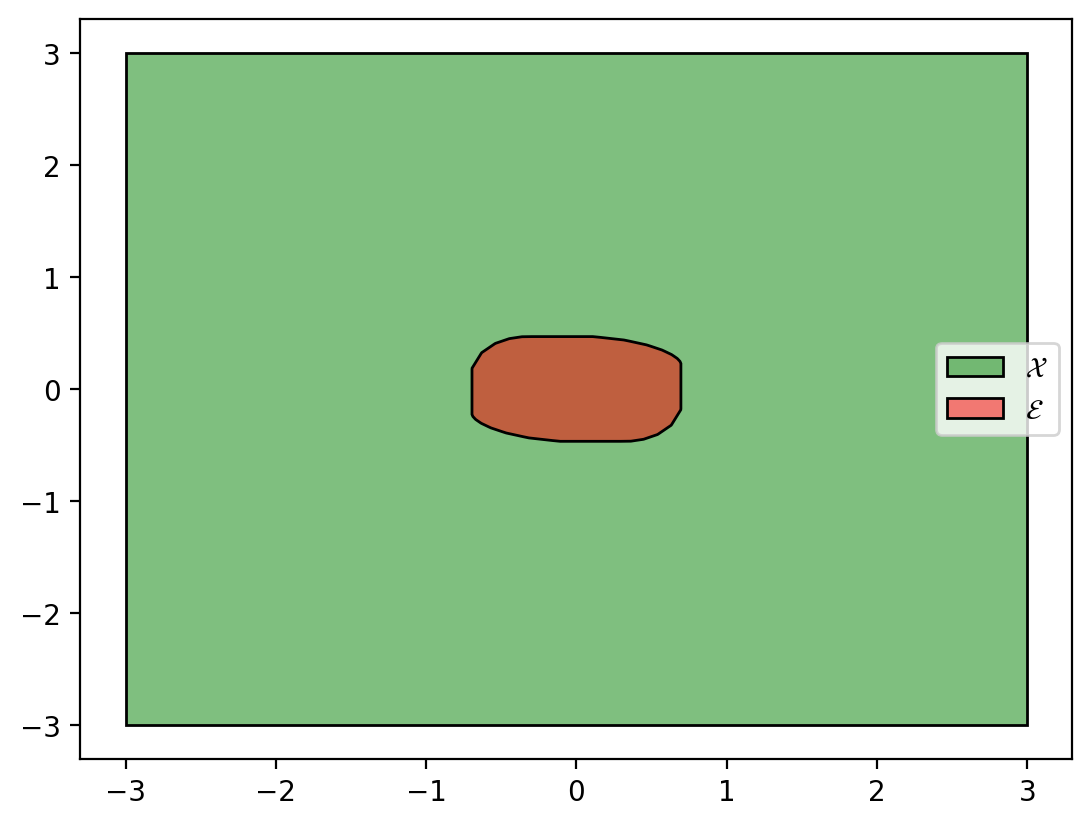

In [2]:
# Compute minimal robust invariant set
def min_robust_invariant_set(A_cl: np.ndarray, W: Polyhedron, max_iter: int = 30) -> Polyhedron:
	# TODO: ------------------
	# TODO: add your code here
	nx = A_cl.shape[0]
	Omega = W
	i = 0
	A_cl_ith_power = np.eye(nx)
	while i < max_iter:
		A_cl_ith_power = np.linalg.matrix_power(A_cl, i)
		Omega_next = Omega + A_cl_ith_power @ W
		Omega_next.minHrep()
		if np.linalg.matrix_norm(A_cl_ith_power, ord=2) < 1e-2:
			print(f'Minimal robust invariant set computation converged after {i} iterations.')
			break
		Omega = Omega_next
		i += 1
	return Omega
	# TODO: ------------------
	

E = min_robust_invariant_set(A_cl, W)

# Visualization
fig1, ax1 = plt.subplots(1, 1)
X.plot(ax1, color='g', opacity=0.5, label=r'$\mathcal{X}$')
E.plot(ax1, color='r', opacity=0.5, label=r'$\mathcal{E}$')
plt.legend()
plt.show()

### Task 2

Compute the tightened state constraints $\tilde{\mathcal{X}} \coloneqq \mathcal{X}\ominus \mathcal{E}$, tightened input constraints $\tilde{\mathcal{U}} \coloneqq \mathcal{U}\ominus K\mathcal{E}$. Plot $\mathcal{\tilde{X}}$ together with $\mathcal{X}$ and $\mathcal{E}$. Does $\mathcal{\tilde{X}}$ match the intuition you developed in Task 1?

Compute the terminal set $\mathcal{X}_f$ for nominal MPC and $\tilde{\mathcal{X}}_f$ for tube MPC. Plot them on a new figure.

**Hints**: 

- You can reuse your code from exercise 3 to compute the terminal set for nominal MPC $\mathcal{X}_f$.

- In mpt4py, the Pontryagin difference of two polyhedra $A\ominus B$ can be easily computed from `A - B` or `A.pontryagin_difference(B)`, where `A` and `B` are two objects of `Polyhedron` class.

- You can compute $K\mathcal{E} := \{ Ke \mid e \in \mathcal{E} \}$ with `E.affine_map(K)` or `K @ E`.

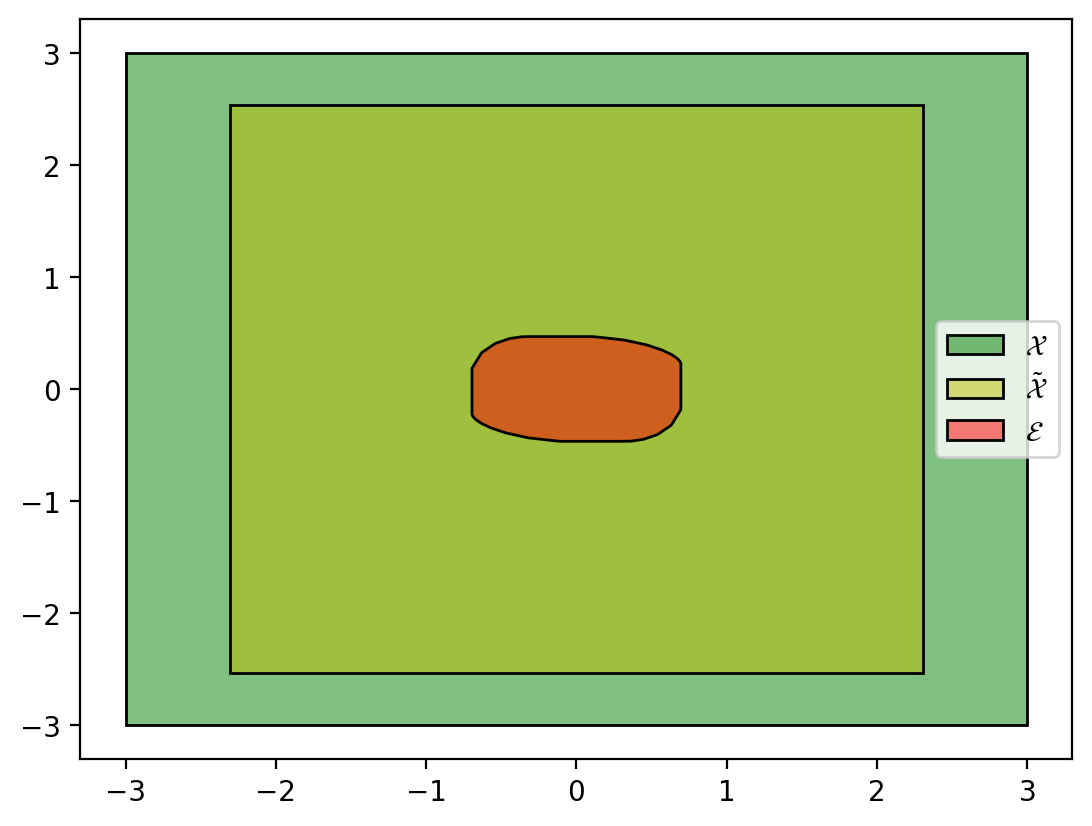

In [3]:

# TODO: ------------------
# TODO: add your code here

# tightened state constraints
X_tilde = X - E

# tightened input constraints
U_tilde = U - K @ E

# TODO: ------------------

# visualization
fig2, ax2 = plt.subplots(1, 1)
X.plot(ax2, color='g', opacity=0.5, label=r'$\mathcal{X}$')
X_tilde.plot(ax2, color='y', opacity=0.5, label=r'$\mathcal{\tilde{X}}$')
E.plot(ax2, color='r', opacity=0.5, label=r'$\mathcal{E}$')
plt.legend()
plt.show()


Iteration 1... not yet converged
Iteration 2... not yet converged
Maximum invariant set successfully computed after 3 iterations.

Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Maximum invariant set successfully computed after 5 iterations.



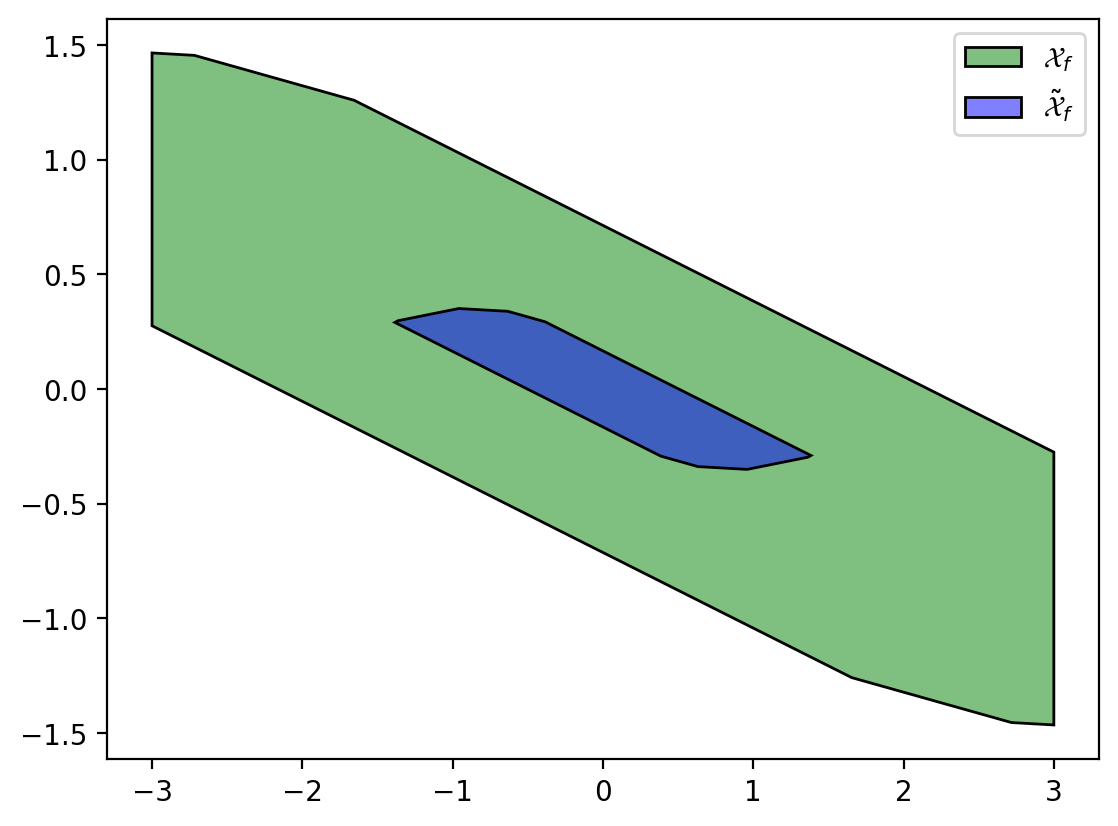

In [4]:

# TODO: ------------------
# TODO: add your code here
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	O = X
	itr = 1
	converged = False
	while itr < max_iter:
		Oprev = O
		F, f = O.A, O.b
		# Compute the pre-set
		O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.vstack((f, f)).reshape((-1,)))
		O.minHrep()
		if O == Oprev:
			converged = True
			break
		print('Iteration {0}... not yet converged'.format(itr))
		itr += 1
	
	if converged:
		print('Maximum invariant set successfully computed after {0} iterations.\n'.format(itr))
	return O



# Compute the terminal set for nominal mpc
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A@K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)

# Compute the terminal set for tube mpc
X_tilde_and_KU_tilde = X_tilde.intersect(Polyhedron.from_Hrep(U_tilde.A@K, U_tilde.b))
Xf_tilde = max_invariant_set(A_cl, X_tilde_and_KU_tilde)

# TODO: ------------------


# visualization
fig3, ax3 = plt.subplots(1, 1)
Xf.plot(ax3, color='g', opacity=0.5, label=r'$\mathcal{X}_f$')
Xf_tilde.plot(ax3, color='b', opacity=0.5, label=r'$\tilde{\mathcal{X}}_f$')
plt.legend()
plt.show()


### Task 3

Formulate the Tube MPC problem using CVXPY.

Use $N=10$ as the prediction horizon.


In [5]:
import cvxpy as cp

N = 10
# Define variables
nx, nu = B.shape
z_var = cp.Variable((N+1, nx), name='z')
v_var = cp.Variable((N, nu), name='v')
x0_var = cp.Parameter((nx,), name='x0')

## Costs
cost = 0
# TODO: ------------------
# TODO: add your code here
for i in range(N):
    cost += cp.quad_form(z_var[i], Q)
    cost += cp.quad_form(v_var[i], R)
cost += cp.quad_form(z_var[-1], Qf)
# TODO: ------------------



# TODO: ------------------
# TODO: add your code here
## Constraints
constraints = [
    E.A @ (x0_var - z_var[0]) <= E.b, # Initial condition: x0 in z0 + E
    z_var[1:].T == A @ z_var[:-1].T + B @ v_var.T, # Dynamics
    X_tilde.A @ z_var[:-1].T <= X_tilde.b.reshape(-1, 1), # State constraints
    U_tilde.A @ v_var[:-1].T <= U_tilde.b.reshape(-1, 1), # Input constraints
    Xf_tilde.A @ z_var[-1].T <= Xf_tilde.b.reshape(-1, 1) # Terminal set
]
# TODO: ------------------


tube_mpc = cp.Problem(cp.Minimize(cost), constraints)

### Task 4

Run closed-loop simulation with the tube MPC controller you designed, and generate several state–input trajectories starting from the same initial condition $x_0$. 

Plot the trajectories and verify that both the state and input constraints are robustly satisfied under the presence of disturbances $w\in\mathcal{W}$.

**Hints:** 

- If $x_0$ is randomly sampled from $\mathcal{\tilde{X}}$, the underlying optimization problem might be infeasible due to the relatively short horizon. To ensure feasibility, an option is to sample initial condition $x_0$ from the terminal set $\mathcal{\tilde{X}}_f$. 

- In *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.

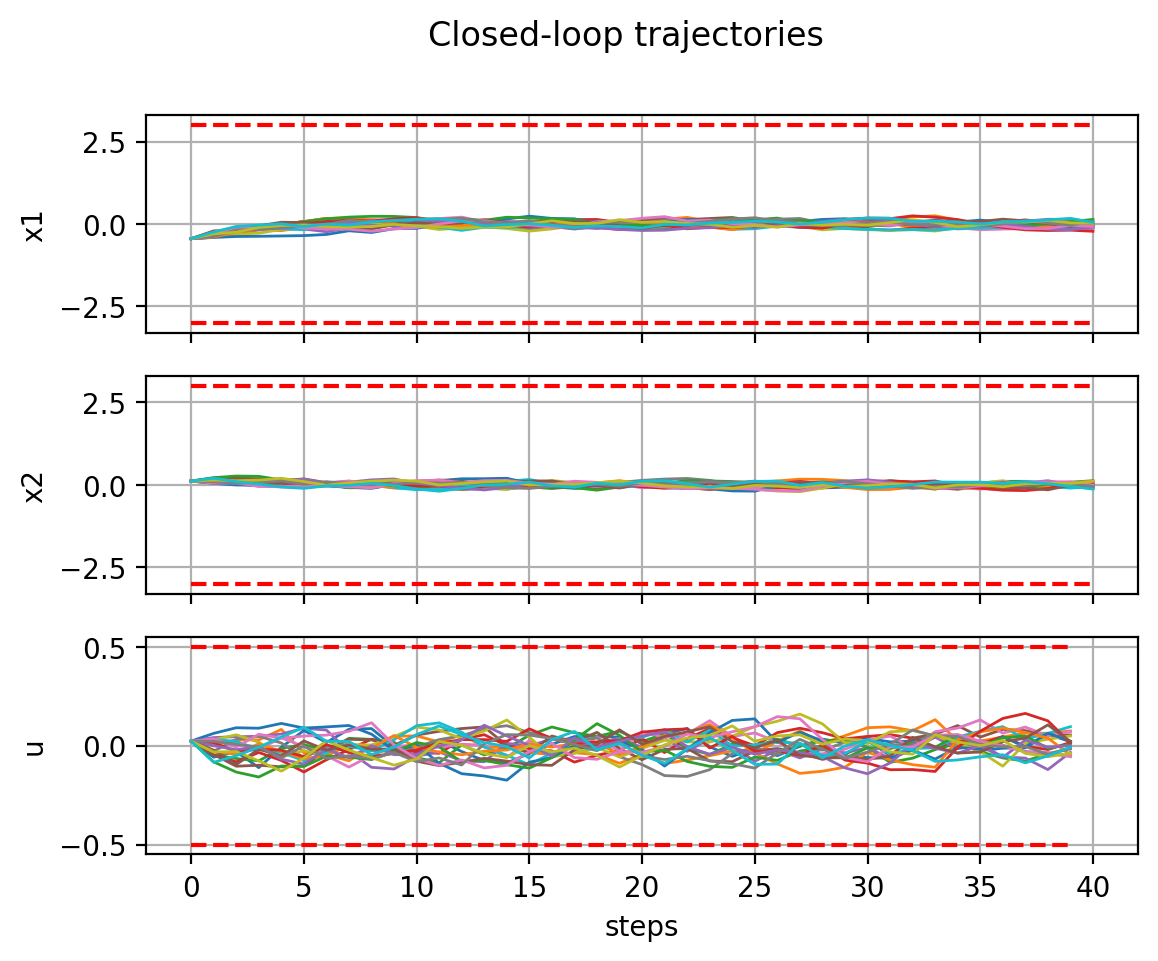

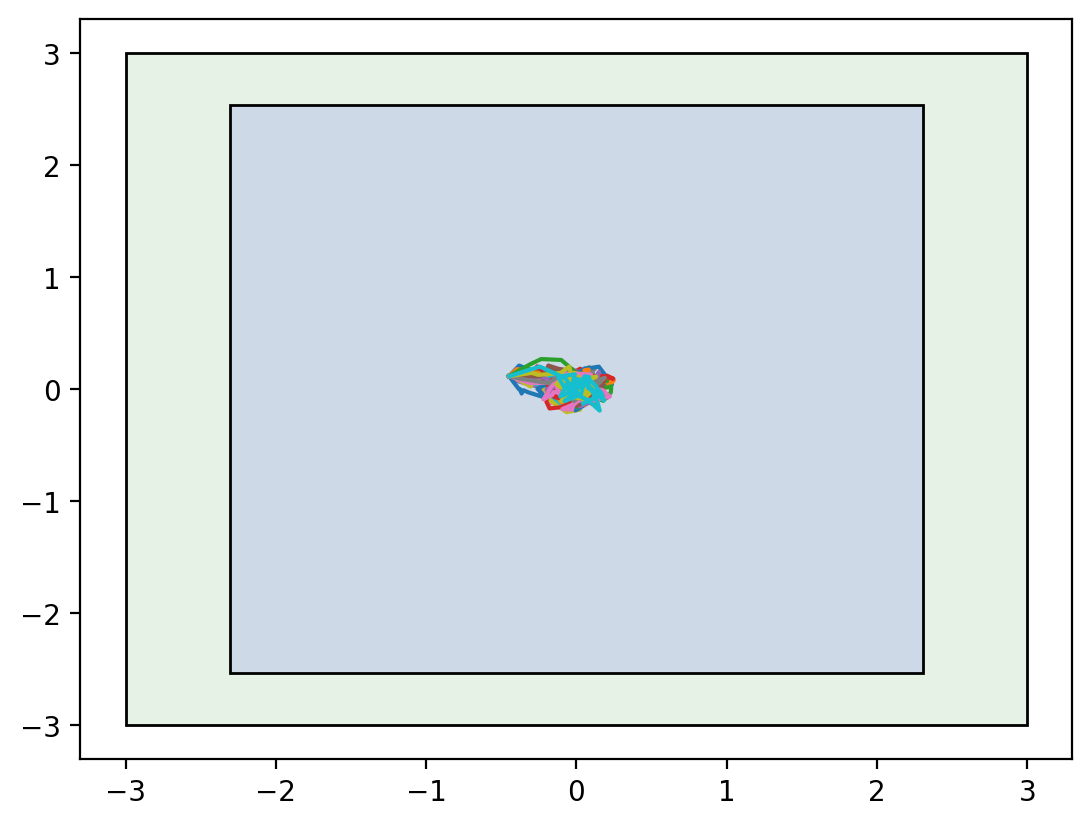

In [7]:

# Closed-loop simulation of the state and input trajectories
num_samples = 20
N_closed_loop = 40
t_traj_closed_loop = np.arange(0, N_closed_loop+1)
x_trajs_closed_loop = np.zeros((num_samples, N_closed_loop+1, nx))
u_trajs_closed_loop = np.zeros((num_samples, N_closed_loop, nu))

x0 = Xf_tilde.sample(1).flatten()

# for each sample trajectory
for i in range(num_samples):
	x_trajs_closed_loop[i, 0] = x0
	xk = x0

	# run closed loop simulation
	for k in range(N_closed_loop):
		x0_var.value = xk
		tube_mpc.solve(cp.PIQP)
		assert tube_mpc.status == cp.OPTIMAL, f"The tube mpc solver returned status: {tube_mpc.status}"
		
		# TODO: ------------------
		# TODO: add your code here
		# after calling solve(), you can obtain the value of a cvxpy variable x with: x.value()
		z0 = z_var[0].value
		v0 = v_var[0].value
		uk = v0 + K @ (xk - z0)
		# TODO: ------------------
		
		wk = W.sample(1).flatten()
		xk = A @ xk + B @ uk + wk
		x_trajs_closed_loop[i, k+1] = xk.flatten()
		u_trajs_closed_loop[i, k] = uk.flatten()


def plot_trajs(t_traj_closed_loop: np.ndarray, 
               x_trajs_closed_loop: np.ndarray,
               u_trajs_closed_loop: np.ndarray):
	# Visualization of the trajectories
	fig, ax = plt.subplots(3, 1, sharex=True)
	t_traj = t_traj_closed_loop
	linewidth=1.

	for x_traj, u_traj in zip(x_trajs_closed_loop, u_trajs_closed_loop):
		ax[0].plot(t_traj, x_traj[:, 0], label=r'$p$', linewidth=linewidth)
		ax[1].plot(t_traj, x_traj[:, 1], label=r'$v$', linewidth=linewidth)
		ax[2].plot(t_traj[:-1], u_traj[:, 0], label=r'$a$', linewidth=linewidth)
		
	ax[0].plot(t_traj, x_max * np.ones_like(t_traj), color='red', linestyle='--')
	ax[0].plot(t_traj, -x_max * np.ones_like(t_traj), color='red', linestyle='--')
	ax[0].grid()
	ax[0].set_ylabel('x1')

	ax[1].plot(t_traj, x_max * np.ones_like(t_traj), color='red', linestyle='--')
	ax[1].plot(t_traj, -x_max * np.ones_like(t_traj), color='red', linestyle='--')
	ax[1].grid()
	ax[1].set_ylabel('x2')

	ax[2].plot(t_traj[:-1], u_max * np.ones_like(t_traj[:-1]), color='red', linestyle='--')
	ax[2].plot(t_traj[:-1], -u_max * np.ones_like(t_traj[:-1]), color='red', linestyle='--')
	ax[2].grid()
	ax[2].set_ylabel('u')
	ax[2].set_xlabel('steps')

	fig.suptitle('Closed-loop trajectories')
	fig.align_ylabels()
	plt.show()
      
plot_trajs(t_traj_closed_loop, x_trajs_closed_loop, u_trajs_closed_loop)    

fig4, ax4 = plt.subplots(1, 1)
X.plot(ax4, opacity=0.1, color='g', label=r'$\mathcal{X}$')
X_tilde.plot(ax4, opacity=0.1, color='b', label=r'\tilde{\mathcal{X}}')

for x_traj in x_trajs_closed_loop:
	ax4.plot(x_traj[:,0], x_traj[:,1])

plt.show()